In [ ]:
# Load all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GRU, GlobalMaxPooling1D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [ ]:
# Pandas and seaborn settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style("darkgrid")

# Check versions
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.version.VERSION)

TensorFlow version: 2.18.0
Keras version: 2.18.0


In [ ]:
# Step 1: Load Dataset
dataset_path = "/content/dataset_full.csv"
data = pd.read_csv(dataset_path)
print("Dataset loaded! Shape:", data.shape)

Dataset loaded! Shape: (88647, 112)


In [ ]:
# Step 2: Data Cleaning & Preprocessing
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

# Boolean to int
bool_cols = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params',
             'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index',
             'url_shortened', 'phishing']
data[bool_cols] = data[bool_cols].astype(int)

# Identify numerical columns
num_cols = [col for col in data.columns if col not in bool_cols]

# Standardize + Normalize
scaler_std = StandardScaler()
data[num_cols] = scaler_std.fit_transform(data[num_cols])
scaler_mm = MinMaxScaler()
data[num_cols] = scaler_mm.fit_transform(data[num_cols])

# Save cleaned dataset
data.to_csv("newphishdata.csv", index=False)

In [ ]:
# Step 4: Train-Test Split
X = data.drop(columns=['phishing'])
y = data['phishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Reshape for Conv1D/GRU input: (samples, timesteps, features)
X_train = np.expand_dims(X_train.values, axis=2)
X_test = np.expand_dims(X_test.values, axis=2)

In [ ]:
# Build faster model
# Lightweight CNN + GRU model
model = Sequential([
    Conv1D(8, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GlobalMaxPooling1D(),  # Replaces large GRU output, speeds up drastically

    Dense(16, activation='relu'),
    Dropout(0.1),

    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile with basic metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 109, 8)              │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 8)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 5: Callbacks
epoch_times = []
def on_epoch_begin(epoch, logs=None):
    global start_time
    start_time = time.time()

def on_epoch_end(epoch, logs=None):
    duration = time.time() - start_time
    epoch_times.append(duration)
    print(f"Epoch {epoch+1} Time: {duration:.2f} sec")

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
time_callback = LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)

In [ ]:
# Step 6: Train Model with Optimized Parameters
history = model.fit(
    X_train, y_train,
    epochs=50,  # Reduce epochs for faster testing
    batch_size=16,  # Smaller batch size for faster computation
    validation_data=(X_test, y_test),
    callbacks=[early_stop, time_callback],
    verbose=1
)

Epoch 1/50
4344/4361 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8626 - loss: 0.3129Epoch 1 Time: 14.51 sec
4361/4361 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8626 - loss: 0.3129 - val_accuracy: 0.8660 - val_loss: 0.3019
Epoch 2/50
4350/4361 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8635 - loss: 0.3094Epoch 2 Time: 20.95 sec
4361/4361 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8635 - loss: 0.3094 - val_accuracy: 0.8668 - val_loss: 0.3034
Epoch 3/50
4350/4361 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8656 - loss: 0.3063Epoch 3 Time: 20.02 sec
4361/4361 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8656 - loss: 0.3063 - val_accuracy: 0.8686 - val_loss: 0.3016
Epoch 4/50
4353/4361 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8655 - loss: 0.3051Epoch 4 Time: 13.56 sec
4361/4361 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8654 - loss: 0.3051 - val_accuracy: 0.8690 - val_loss: 0.3025
Epoch 5/50
4353/4361 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8632 - l

In [ ]:
# Step 7: Evaluate
y_pred = (model.predict(X_test) > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Avg Epoch Time: {np.mean(epoch_times):.2f} seconds")

546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Evaluation Metrics:
Accuracy: 0.8665
Precision: 0.7342
Recall: 0.9692
AUC: 0.8903
Confusion Matrix:
[[9203 2140]
 [ 188 5911]]
Avg Epoch Time: 16.98 seconds


In [ ]:
# Step 8: FAR and FRR
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]

far = fp / (fp + tn)
frr = fn / (fn + tp)

print(f"\nFalse Acceptance Rate (FAR): {far:.4f}")
print(f"False Rejection Rate (FRR): {frr:.4f}")


False Acceptance Rate (FAR): 0.1887
False Rejection Rate (FRR): 0.0308


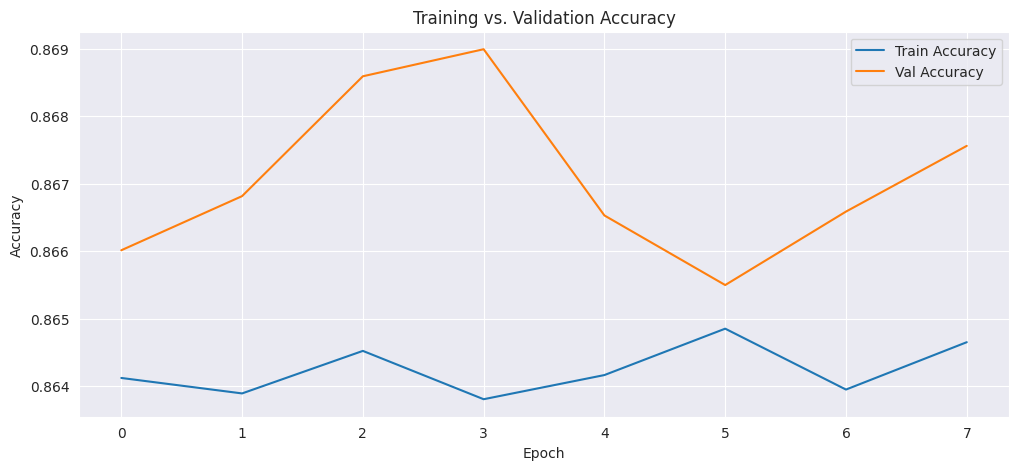

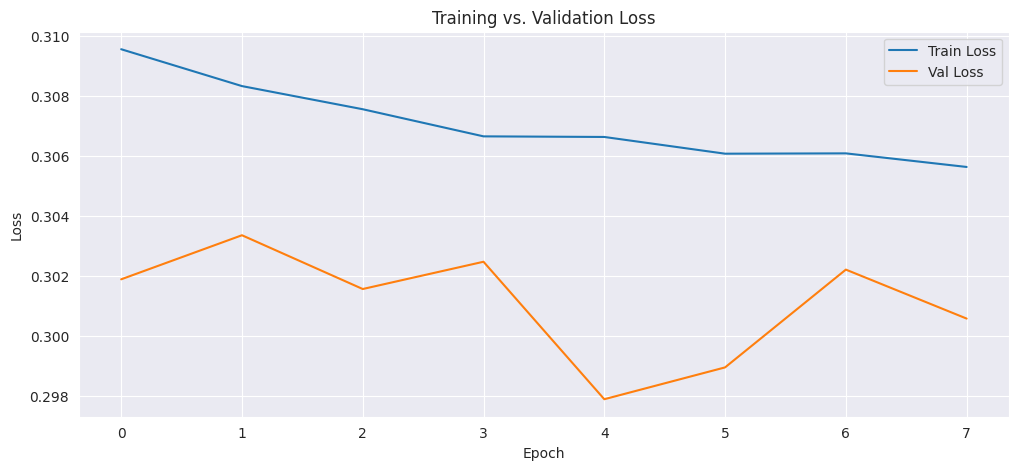

In [ ]:
# Step 9: Plot Accuracy & Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()